In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_columns = 999
sns.set_style('whitegrid')

# https://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
df = pd.read_csv('PHL_Building_Dataset_ML_Regression.csv')
df = df.drop(columns=['Unnamed: 0', 'building_code_description', 'depth', 'frontage', 'location',
                     'number_of_bathrooms', 'number_of_bedrooms', 'year_built', 'zoning', 'segment'])
df

# from our EDA these are several columns that will be used for our next step

,basements,central_air,exterior_condition,fireplaces,garage_type,interior_condition,market_value,number_of_rooms,number_stories,parcel_shape,street_designation,topography,total_area,total_livable_area,type_heater,view_type,building_description,section
0,0,Y,4.0,0.0,A,4.0,257500.0,6.0,2.0,E,ST,6,2625.30,1266.0,H,I,MASONRY,South
1,0,Y,4.0,0.0,A,4.0,249400.0,6.0,2.0,E,ST,6,1622.70,1266.0,A,I,MASONRY,South
2,0,Y,4.0,0.0,A,4.0,249500.0,6.0,2.0,E,ST,6,1624.50,1266.0,A,I,MASONRY,South
3,0,Y,4.0,0.0,A,4.0,249500.0,6.0,2.0,E,ST,6,1627.20,1266.0,H,I,MASONRY,South
4,0,Y,4.0,0.0,A,4.0,253800.0,6.0,2.0,E,ST,6,1683.90,1310.0,H,I,MASONRY,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44479,D,N,4.0,0.0,0,4.0,117500.0,6.0,3.0,A,ST,6,1651.00,2907.0,H,I,MASONRY,North
44480,D,Y,3.0,0.0,0,3.0,70800.0,9.0,3.0,A,ST,6,1811.00,2026.0,A,I,MASONRY,South
44481,D,Y,3.0,0.0,0,3.0,23600.0,6.0,3.0,A,ST,6,1604.00,2082.0,A,I,MASONRY,South
44482,D,Y,3.0,0.0,0,3.0,23600.0,6.0,3.0,E,ST,6,1440.00,1387.0,A,I,MASONRY,South


In [5]:
df.to_csv('PHL_Building_Dataset_Recommendation_Mini.csv', index=False)
# We will use it later for Recommendation System

In [6]:
df2 = pd.read_csv('PHL_Building_Dataset_ML_Regression.csv')
df2 = df2.drop(columns=['Unnamed: 0', 'building_code_description', 'segment'])
df2.to_csv('PHL_Building_Dataset_Recommendation_Big.csv', index=False)
# We will use it later for Recommendation System

# Splitting Data

In [7]:
X = df.drop(columns=['market_value'])
y = df['market_value']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Evaluation Matrix

In [9]:
# Evaluation Matrix Regression
def Eva_Matrix(Model, X_train, y_train, X_test, y_test, Name):
    y_pred_train = Model.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    y_pred_test = Model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    data = {
        f"Training {Name}" : [r2_train, mae_train, mse_train, rmse_train],
        f"Test {Name}" : [r2_test, mae_test, mse_test, rmse_test]
    }
    df = pd.DataFrame(data=data, index=['R2', 'MAE', 'MSE', 'RMSE'])
    return df

# Pipeline

In [10]:
# Based on EDA there are several columns that we choose for Machine Learning Modelling
num_columns = ['fireplaces', 'number_of_rooms', 'number_stories', 'total_area', 
               'total_livable_area']

cat_columns = ['basements', 'central_air', 'exterior_condition', 'garage_type',
               'interior_condition', 'parcel_shape', 'street_designation', 'topography',
               'type_heater', 'view_type', 'building_description', 'section']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()),
    #('poly', PolynomialFeatures(degree=3, include_bias=False)),
    #('power', PowerTransformer(method='yeo-johnson'))
])

categoric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categoric', categoric_pipeline, cat_columns)
])

pipeSVM = Pipeline([
    ("prep", preprocessor),
    ("algo", SVR(max_iter=400))
])

pipeLR = Pipeline([
    ("prep", preprocessor),
    ("algo", LinearRegression())
])

pipeLasso = Pipeline([
    ("prep", preprocessor),
    ("algo", Lasso())
])

pipeRidge = Pipeline([
    ("prep", preprocessor),
    ("algo", Ridge())
])

pipeElasticNet = Pipeline([
    ("prep", preprocessor),
    ("algo", ElasticNet())
])

pipeKNN = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsRegressor())
])
               
pipeDT = Pipeline([
    ("prep", preprocessor),
    ("algo", DecisionTreeRegressor())
])
            
pipeRF = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestRegressor())
])

# =================================================

# Base Model KNN

In [11]:
pipeKNN.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['fireplaces',
                                                   'number_of_rooms',
                                                   'number_stories',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen

In [12]:
y_KNN_test = pipeKNN.predict(X_test)

In [13]:
df_KNN = Eva_Matrix(pipeKNN, X_train, y_train, X_test, y_test, "Pipeline KNN")
df_KNN

,Training Pipeline KNN,Test Pipeline KNN
R2,8.877066e-01,8.219156e-01
MAE,1.671228e+04,2.230613e+04
MSE,2.042664e+09,3.706225e+09
RMSE,4.519584e+04,6.087877e+04


# Base Model Linear Regression

In [14]:
pipeLR.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['fireplaces',
                                                   'number_of_rooms',
                                                   'number_stories',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen

In [15]:
y_LR_test = pipeLR.predict(X_test)

In [16]:
df_LR = Eva_Matrix(pipeLR, X_train, y_train, X_test, y_test, "Pipeline LR")
df_LR

,Training Pipeline LR,Test Pipeline LR
R2,7.930901e-01,7.904972e-01
MAE,3.572717e+04,3.690226e+04
MSE,3.763777e+09,4.360093e+09
RMSE,6.134963e+04,6.603100e+04


# Base Model Ridge

In [18]:
pipeRidge.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['fireplaces',
                                                   'number_of_rooms',
                                                   'number_stories',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen

In [19]:
y_Ridge_test = pipeRidge.predict(X_test)

In [20]:
df_Ridge = Eva_Matrix(pipeRidge, X_train, y_train, X_test, y_test, "Pipeline Ridge")
df_Ridge

,Training Pipeline Ridge,Test Pipeline Ridge
R2,7.918528e-01,7.876871e-01
MAE,3.585954e+04,3.712539e+04
MSE,3.786284e+09,4.418576e+09
RMSE,6.153279e+04,6.647237e+04


# Base Model Lasso

In [21]:
pipeLasso.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['fireplaces',
                                                   'number_of_rooms',
                                                   'number_stories',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen

In [22]:
y_Lasso_test = pipeLasso.predict(X_test)

In [23]:
df_Lasso = Eva_Matrix(pipeLasso, X_train, y_train, X_test, y_test, "Pipeline Lasso")
df_Lasso

,Training Pipeline Lasso,Test Pipeline Lasso
R2,7.930854e-01,7.904134e-01
MAE,3.572843e+04,3.690935e+04
MSE,3.763862e+09,4.361837e+09
RMSE,6.135032e+04,6.604421e+04


# Base Model ElasticNet

In [24]:
pipeElasticNet.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['fireplaces',
                                                   'number_of_rooms',
                                                   'number_stories',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen

In [25]:
y_ElasticNet_test = pipeElasticNet.predict(X_test)

In [26]:
df_ElasticNet = Eva_Matrix(pipeElasticNet, X_train, y_train, X_test, y_test, "Pipeline ElasticNet")
df_ElasticNet

,Training Pipeline ElasticNet,Test Pipeline ElasticNet
R2,7.090427e-01,7.131638e-01
MAE,4.142793e+04,4.291701e+04
MSE,5.292635e+09,5.969525e+09
RMSE,7.275050e+04,7.726270e+04


# Base Model SVM

In [27]:
pipeSVM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['fireplaces',
                                                   'number_of_rooms',
                                                   'number_stories',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen

In [28]:
y_SVM_test = pipeSVM.predict(X_test)

In [29]:
df_SVM = Eva_Matrix(pipeSVM, X_train, y_train, X_test, y_test, "Pipeline SVM")
df_SVM

,Training Pipeline SVM,Test Pipeline SVM
R2,-2.162244e+00,-1.850345e+00
MAE,2.210231e+05,2.224821e+05
MSE,5.752253e+10,5.932029e+10
RMSE,2.398385e+05,2.435576e+05


# Base Model DecisionTreeRegressor

In [30]:
pipeDT.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['fireplaces',
                                                   'number_of_rooms',
                                                   'number_stories',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen

In [31]:
y_DT_test = pipeDT.predict(X_test)

In [32]:
df_DT = Eva_Matrix(pipeDT, X_train, y_train, X_test, y_test, "Pipeline DT")
df_DT

,Training Pipeline DT,Test Pipeline DT
R2,9.998053e-01,7.231839e-01
MAE,2.440770e+02,2.628013e+04
MSE,3.541711e+06,5.760991e+09
RMSE,1.881943e+03,7.590119e+04


# Base Model RandomForestRegressor

In [33]:
pipeRF.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['fireplaces',
                                                   'number_of_rooms',
                                                   'number_stories',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen

In [34]:
y_RF_test = pipeRF.predict(X_test)

In [35]:
df_RF = Eva_Matrix(pipeRF, X_train, y_train, X_test, y_test, "Pipeline RF")
df_RF

,Training Pipeline RF,Test Pipeline RF
R2,9.814888e-01,8.693393e-01
MAE,6.964658e+03,1.938911e+04
MSE,3.367270e+08,2.719262e+09
RMSE,1.835012e+04,5.214654e+04


# =================================================

# Hyper Parameter Tuning

## KNN

In [36]:
param_KNN = {
    'algo__n_neighbors': np.arange(1,21,2),
    "algo__p" : [1,2],
    'algo__weights' : ['uniform', 'distance']
}

KNN_GS = GridSearchCV(pipeKNN, param_KNN, cv = 3, scoring = 'r2', n_jobs= -1, verbose = 1)
KNN_GS.fit(X_train,y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 32.0min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['fireplaces',
                                                                          'number_of_rooms',
                                                                          'number_stories',
                                                                          'total_area',
                                                                      

In [37]:
KNN_GS.best_params_

{'algo__n_neighbors': 7, 'algo__p': 1, 'algo__weights': 'distance'}

In [38]:
KNN_Hyper_Tuning = KNN_GS.best_estimator_

In [39]:
df_KNN_Hyper_Tuned = Eva_Matrix(KNN_Hyper_Tuning, X_train, y_train, X_test, y_test, "Hyper Parameter Tuning KNN")
df_KNN_Hyper_Tuned

,Training Hyper Parameter Tuning KNN,Test Hyper Parameter Tuning KNN
R2,9.998015e-01,8.426430e-01
MAE,2.453539e+02,2.011705e+04
MSE,3.610439e+06,3.274855e+09
RMSE,1.900116e+03,5.722635e+04


## DecisionTreeRegressor

In [40]:
param_DT = {
   'algo__max_depth': [None, 5, 10, 15], 
   'algo__min_samples_leaf' : np.arange(1, 17, 5), 
   'algo__max_features' : [0.3, 0.5, 0.7, 0.8]
}

DT_GS = GridSearchCV(pipeDT, param_DT, cv = 3, scoring = 'r2', n_jobs= -1, verbose = 1)
DT_GS.fit(X_train,y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  2.3min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['fireplaces',
                                                                          'number_of_rooms',
                                                                          'number_stories',
                                                                          'total_area',
                                                                      

In [41]:
DT_GS.best_params_

{'algo__max_depth': None,
 'algo__max_features': 0.8,
 'algo__min_samples_leaf': 6}

In [42]:
DT_Hyper_Tuning = DT_GS.best_estimator_

In [43]:
df_DT_Hyper_Tuned = Eva_Matrix(DT_Hyper_Tuning, X_train, y_train, X_test, y_test, "Hyper Parameter Tuning DT")
df_DT_Hyper_Tuned

,Training Hyper Parameter Tuning DT,Test Hyper Parameter Tuning DT
R2,9.087745e-01,8.066855e-01
MAE,1.688487e+04,2.571332e+04
MSE,1.659430e+09,4.023188e+09
RMSE,4.073610e+04,6.342861e+04


# =================================================

# Fine Tuning

## DecisionTreeRegressor

In [44]:
pipeDT_Tuning = Pipeline([
    ("prep", preprocessor),
    ("algo", DecisionTreeRegressor(max_depth = None, max_features = 0.9, min_samples_leaf = 25, min_samples_split = 24, random_state=42))
])

In [45]:
pipeDT_Tuning.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['fireplaces',
                                                   'number_of_rooms',
                                                   'number_stories',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen

In [46]:
y_DT_Fine_Tuned_train = pipeDT_Tuning.predict(X_train)

In [47]:
y_DT_Fine_Tuned_test = pipeDT_Tuning.predict(X_test)

In [48]:
df_DT_Fine_Tuned = Eva_Matrix(pipeDT_Tuning, X_train, y_train, X_test, y_test, "Pipeline DT Tuned")
df_DT_Fine_Tuned

,Training Pipeline DT Tuned,Test Pipeline DT Tuned
R2,8.291246e-01,7.939786e-01
MAE,2.485831e+04,2.876584e+04
MSE,3.108295e+09,4.287638e+09
RMSE,5.575209e+04,6.548006e+04


# =================================================

# Conclusion Model

## Base Model

In [71]:
df_base_model = pd.concat([df_KNN , df_LR , df_Ridge , df_Lasso , df_ElasticNet , df_SVM , df_DT , df_RF], join = 'outer', axis = 1)
df_base_model.T

,R2,MAE,MSE,RMSE
Training Pipeline KNN,0.887707,16712.280889,2.042664e+09,45195.837363
Test Pipeline KNN,0.821916,22306.130156,3.706225e+09,60878.773234
Training Pipeline LR,0.793090,35727.169654,3.763777e+09,61349.626400
Test Pipeline LR,0.790497,36902.260679,4.360093e+09,66030.997116
Training Pipeline Ridge,0.791853,35859.540267,3.786284e+09,61532.787461
Test Pipeline Ridge,0.787687,37125.386366,4.418576e+09,66472.373309
Training Pipeline Lasso,0.793085,35728.425685,3.763862e+09,61350.318283
Test Pipeline Lasso,0.790413,36909.352969,4.361837e+09,66044.208300
Training Pipeline ElasticNet,0.709043,41427.927722,5.292635e+09,72750.495367
Test Pipeline ElasticNet,0.713164,42917.006557,5.969525e+09,77262.701760


## Hyper Parameter Tuning

In [72]:
df_hyper_tuning = pd.concat([df_KNN_Hyper_Tuned, df_DT_Hyper_Tuned], join = 'outer', axis = 1)
df_hyper_tuning.T

,R2,MAE,MSE,RMSE
Training Hyper Parameter Tuning KNN,0.999802,245.353948,3.610439e+06,1900.115546
Test Hyper Parameter Tuning KNN,0.842643,20117.049535,3.274855e+09,57226.346654
Training Hyper Parameter Tuning DT,0.908774,16884.869546,1.659430e+09,40736.099919
Test Hyper Parameter Tuning DT,0.806685,25713.315834,4.023188e+09,63428.608728


## Fine Tuning

In [73]:
df_DT_Fine_Tuned.T

,R2,MAE,MSE,RMSE
Training Pipeline DT Tuned,0.829125,24858.311751,3.108295e+09,55752.085395
Test Pipeline DT Tuned,0.793979,28765.839568,4.287638e+09,65480.059976


# =================================================

# Conclusion

These are the results from our testings using several models. KNN, DecisionTreeClassifier, RandomForestClassifier is having an overfit result in their R2 score predictions while other models such as LinearRegression, Ridge, Lasso and ElasticNet is having better results. Then we will be doing Hyper Parameter Tuning to try to get better results but KNN and DecisionTree  is still producing an overfit results. So, we decided to do Fine Tuning for DecisionTreeClassifier and achieved a R2 score of 0.829 in Train Data and 0.793 in Test Data. We decided to use the results from our Fine Tuned DecisionTreeClassifier.


# =================================================

# Joblib Model Pipeline Fine Tuning DecisionTreeRegressor

In [49]:
import joblib

In [50]:
joblib.dump(pipeDT_Tuning, 'Model_PHL_Building_Regressor_DT')

['Model_PHL_Building_Regressor_DT']

# Residual Plot

In [51]:
error = abs(y_DT_Fine_Tuned_test - y_test)

In [52]:
df_test = pd.concat([X_test, y_test], axis=1)

In [53]:
df_test['y_pred'] = y_DT_Fine_Tuned_test

In [54]:
df_test['error'] = error

In [56]:
error1 = abs(y_DT_Fine_Tuned_train - y_train)

In [57]:
df_train = pd.concat([X_train, y_train], axis=1)

In [58]:
df_train['y_pred'] = y_DT_Fine_Tuned_train

In [59]:
df_train['error'] = error1

In [61]:
tigaratusrebu = df_test[df_test['error'] > 500000].sort_values(by='error',ascending=False)
tigaratusrebu1 = df_train[df_train['error'] > 500000].sort_values(by='error',ascending=False)

In [62]:
tigaratusrebu

,basements,central_air,exterior_condition,fireplaces,garage_type,interior_condition,number_of_rooms,number_stories,parcel_shape,street_designation,topography,total_area,total_livable_area,type_heater,view_type,building_description,section,market_value,y_pred,error
2240,B,Y,2.0,3.0,C,2.0,16.0,3.0,B,AVE,2,127979.00,7249.0,H,C,STONE,North West,3008700.0,1.245631e+06,1.763069e+06
447,C,Y,3.0,0.0,0,3.0,17.0,3.0,E,PL,1,1944.00,3688.0,A,I,MASONRY,Central City,2054100.0,7.804606e+05,1.273639e+06
444,F,Y,3.0,0.0,A,3.0,7.0,4.0,E,ST,1,3634.80,3714.0,B,I,MASONRY,South,1658000.0,4.251700e+05,1.232830e+06
16694,C,N,5.0,5.0,C,5.0,20.0,0.0,A,RD,6,51750.00,9950.0,B,I,STONE,North West,468900.0,1.514593e+06,1.045693e+06
1319,A,Y,3.0,4.0,A,3.0,12.0,0.0,B,LA,6,50110.00,6214.0,A,C,MASONRY+OTHER,North West,2079200.0,1.154952e+06,9.242480e+05
13451,G,Y,2.0,2.0,C,2.0,21.0,3.0,A,RD,6,55361.32,8055.0,A,C,STONE,North West,709800.0,1.514593e+06,8.047933e+05
2333,F,Y,2.0,5.0,B,2.0,12.0,0.0,E,AVE,1,136199.05,7025.0,E,C,STONE,North West,2012200.0,1.245631e+06,7.665690e+05
5195,D,Y,3.0,0.0,A,3.0,10.0,2.0,E,ST,6,2741.39,3788.0,A,I,MASONRY,North,1079900.0,4.251700e+05,6.547300e+05
248,H,Y,3.0,0.0,A,3.0,7.0,3.0,B,CT,6,2003.00,2082.0,A,I,MASONRY,South,929400.0,3.018656e+05,6.275344e+05
2239,D,Y,3.0,5.0,C,3.0,10.0,3.0,B,AVE,6,79781.00,9450.0,A,C,STONE,North West,2079200.0,1.514593e+06,5.646067e+05


In [63]:
pd.crosstab(index=tigaratusrebu['building_description'], columns='count')

col_0,count
building_description,
MASONRY,4
MASONRY+OTHER,1
STONE,8


In [64]:
tigaratusrebu1.sort_values(by='building_description', ascending=True)

,basements,central_air,exterior_condition,fireplaces,garage_type,interior_condition,number_of_rooms,number_stories,parcel_shape,street_designation,topography,total_area,total_livable_area,type_heater,view_type,building_description,section,market_value,y_pred,error
1193,E,Y,3.0,1.0,B,3.0,9.0,2.0,B,RD,1,61209.00,6864.0,A,C,FRAME,North West,2020300.0,1.245631e+06,7.746690e+05
443,E,Y,2.0,1.0,A,2.0,4.0,2.0,A,ST,1,2022.72,1152.0,A,I,MASONRY,Central City,806400.0,1.798298e+05,6.265702e+05
23746,J,Y,4.0,0.0,0,4.0,14.0,3.0,E,ST,6,3034.00,6820.0,B,I,MASONRY,North,294300.0,8.611388e+05,5.668388e+05
5171,C,Y,2.0,0.0,C,2.0,7.0,2.0,E,ST,6,2100.00,2700.0,A,I,MASONRY,North,1043700.0,4.828943e+05,5.608057e+05
247,H,Y,3.0,4.0,0,3.0,11.0,3.0,E,ST,6,1659.80,3452.0,B,I,MASONRY,Central City,1337700.0,7.804606e+05,5.572394e+05
242,D,Y,3.0,1.0,0,3.0,7.0,3.0,E,PL,6,1797.60,2520.0,A,I,MASONRY,Central City,1119700.0,4.828943e+05,6.368057e+05
20354,D,Y,4.0,0.0,0,4.0,10.0,3.0,E,ST,6,2204.00,3184.0,H,I,MASONRY,South,238300.0,7.804606e+05,5.421606e+05
182,A,Y,3.0,3.0,A,3.0,6.0,3.0,E,ST,6,1728.00,2634.0,A,I,MASONRY,South,1192100.0,4.828943e+05,7.092057e+05
244,H,N,3.0,0.0,0,3.0,7.0,2.0,E,ST,6,1530.62,1712.0,B,I,MASONRY,Central City,751900.0,2.138909e+05,5.380091e+05
164,A,Y,2.0,2.0,A,2.0,8.0,3.0,E,ST,6,1653.60,3856.0,A,I,MASONRY,South,1371400.0,7.804606e+05,5.909394e+05


In [65]:
pd.crosstab(index=tigaratusrebu1['building_description'], columns='count')

col_0,count
building_description,
FRAME,1
MASONRY,16
MASONRY+OTHER,3
STONE,21


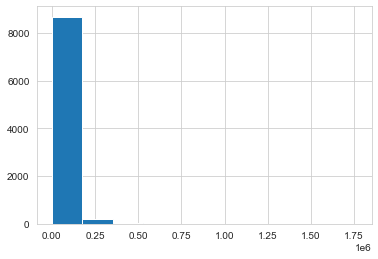

In [66]:
plt.hist(df_test['error'])
plt.show()

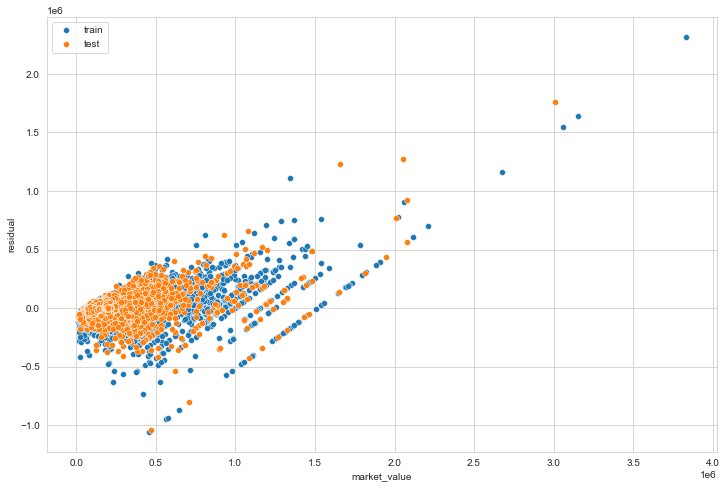

In [68]:
y_predict = pipeDT_Tuning.predict(X_train)
df['residual'] = y_train - y_predict
y_predict1 = pipeDT_Tuning.predict(X_test)
df['residual1'] = y_test - y_predict1
plt.figure(figsize=(12,8))
sns.scatterplot(x='market_value', y='residual', data=df)
sns.scatterplot(x='market_value', y='residual1', data=df)
plt.legend(['train','test'])
plt.show()

From our model, we found several errors that need to be addressed. The first one is **MASONRY** type building around central city and south area, the actual pricing is high while our machine predicted them to be low.

The second one is **STONE** type houses. Most of them are old houses with a large area and the machine is having troubles with this specific scenario, therefore people with expertise in this area will be better in recommending.

The machine we will be using is limited by previously discussed problems.

# =================================================

# Alternative - Fine Tuning (For Explaining Tree Algorithm)

We make another type Model DecisionTreeRegressor with max_depth = 3, max_features = 0.5, min_samples_leaf = 2, min_samples_split = 4 for easier to explaining Tree Algorithm from DecisionTreeRegressor.

## DecisionTreeRegressor

In [214]:
pipeDT_Tuning1 = Pipeline([
    ("prep", preprocessor),
    ("algo", DecisionTreeRegressor(max_depth = 3, max_features = 0.5, min_samples_leaf = 2, min_samples_split = 4, random_state=42))
])

In [215]:
pipeDT_Tuning1.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['fireplaces',
                                                   'number_of_rooms',
                                                   'number_stories',
                                                   'total_area',
                                                   'total_livable_area']),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen

In [216]:
y_DT_Fine_Tuned_train1 = pipeDT_Tuning1.predict(X_train)

In [217]:
y_DT_Fine_Tuned_test1 = pipeDT_Tuning1.predict(X_test)

In [218]:
df_DT_Fine_Tuned1 = Eva_Matrix(pipeDT_Tuning1, X_train, y_train, X_test, y_test, "Pipeline DT Tuned Algorithm")
df_DT_Fine_Tuned1

,Training Pipeline DT Tuned Algorithm,Test Pipeline DT Tuned Algorithm
R2,6.237698e-01,6.290106e-01
MAE,4.890032e+04,5.062049e+04
MSE,6.843783e+09,7.720891e+09
RMSE,8.272716e+04,8.786860e+04


# Tree

In [219]:
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree

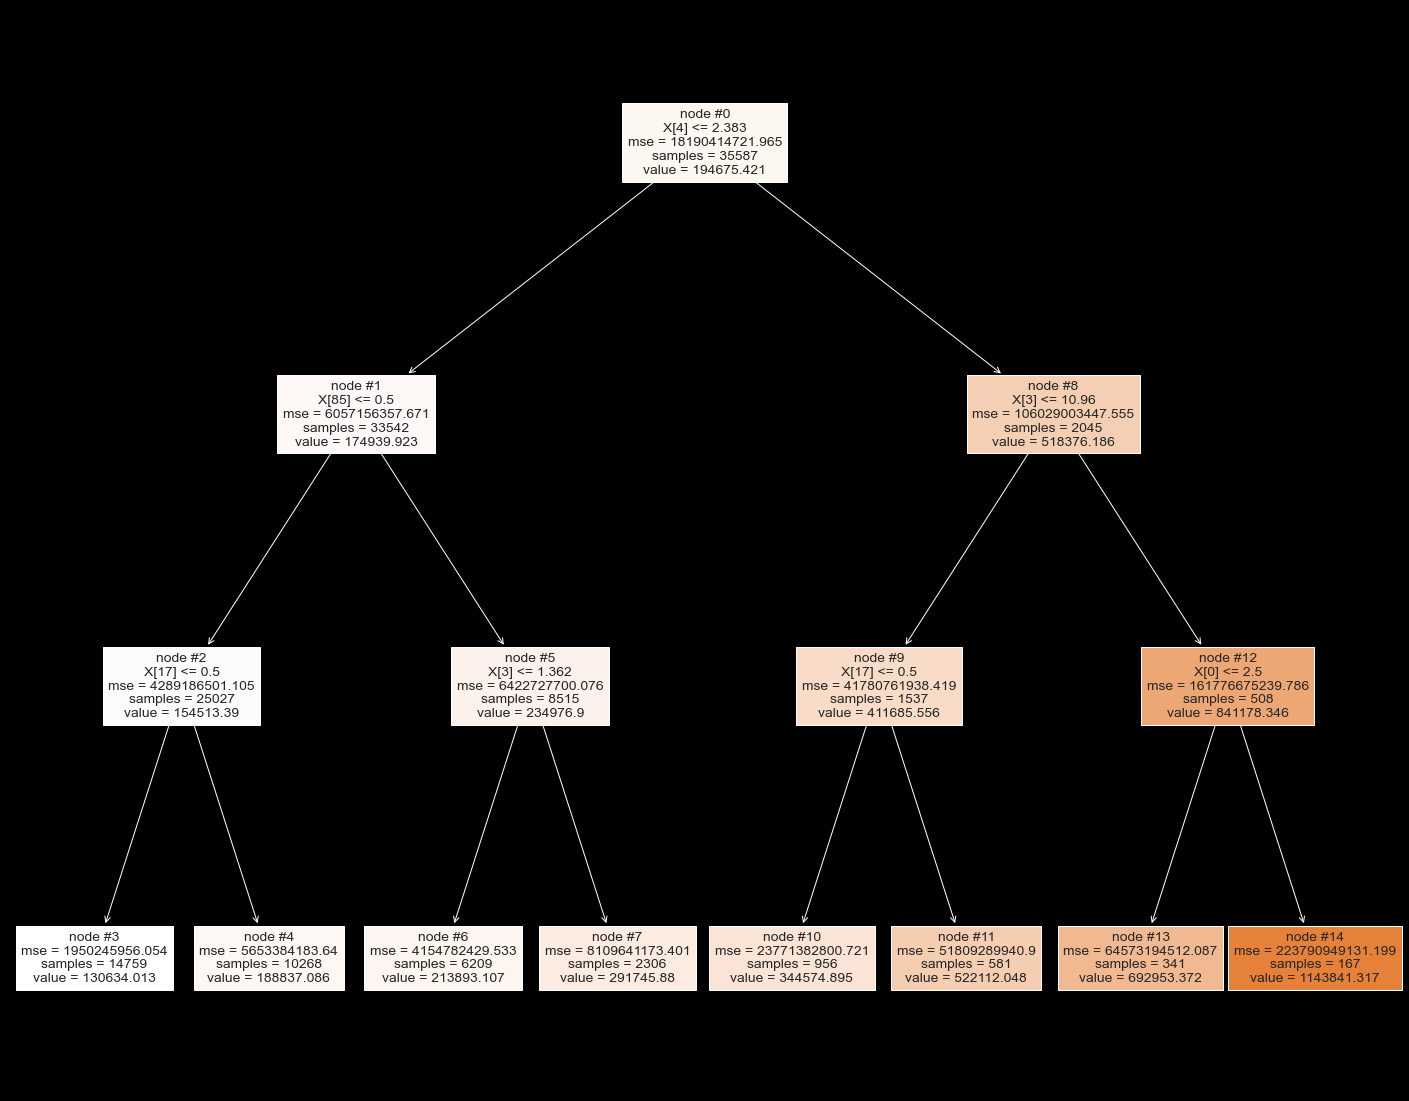

In [234]:
fig, ax = plt.subplots(figsize=(25, 20), facecolor='k')
_ = tree.plot_tree(pipeDT_Tuning1[1], filled=True, node_ids = True, ax=ax)
plt.savefig('tree_regression.png')